In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\Donat\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Variables

In [4]:
num_topics = 5
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## Load data

In [5]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus

corpus = load_data()

## Preprocessing

In [6]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0it [00:00, ?it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:02, 433.42it/s]


### TD-IDF

In [7]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])

# Clustering

In [8]:
tdidf_dbscan_clustering = DBSCAN(min_samples=3, eps=1, n_jobs=6)
tdidf_dbscan_clustering.fit(tfidf_corpus.toarray())

DBSCAN(eps=1, min_samples=3, n_jobs=6)

In [9]:
pickle.dump(tdidf_dbscan_clustering, open('dbscan_data/tdidf_dbscan_clustering', 'wb'))

In [12]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, corpus):
    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if (n_clusters_ == 0):
        print('No clusters found')
        return
    
    clusters = []
    print("Top terms per cluster:")
    for i in range(n_clusters_):
        print("Cluster %d:" % i)
        vectorizer_terms = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
        tfidf_corpus_terms = vectorizer_terms.fit_transform(corpus.iloc[np.where(model.labels_ == i)]["token"])
        top_words = get_top_words(vectorizer_terms, tfidf_corpus_terms)
        print(top_words)
        clusters.append(top_words)
        print("\n")
    return clusters

In [11]:
clusters = print_and_get_clusters(tdidf_dbscan_clustering, corpus)

Top terms per cluster:
Cluster 0:
('derivative', 'method', 'regression', 'estimator', 'bias', 'difference', 'function', 'sequence', 'square', 'design')


Cluster 1:
('classifier', 'type', 'np', 'error', 'classification', 'class', 'neyman', 'pearson', 'anomaly', 'paradigm')


Cluster 2:
('tensor', 'rank', 'completion', 'sampling', 'given', 'clustering', 'space', 'data', 'cp', 'problem')


Cluster 3:
('gabp', 'algorithm', 'convergence', 'gaussian', 'definite', 'positive', 'multivariate', 'node', 'extension', 'mg')




# Visualization

In [13]:
def visualize_clustering_result_arr(model, X):
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    if (n_clusters_ == 0):
        print('No clusters found')
        return
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
def visualize_clustering_result(model, corpus):
    visualize_clustering_result_arr(model, corpus.toarray())

Estimated number of clusters: 4
Estimated number of noise points: 1249


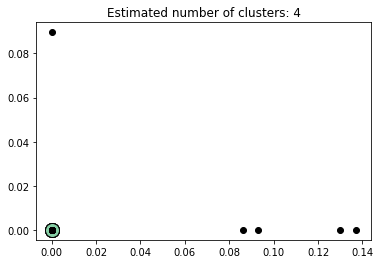

In [13]:
visualize_clustering_result(tdidf_dbscan_clustering, tfidf_corpus)

# Try different arguments for `DBSCAN`

min_samples: 3, eps: 0.1
No clusters found
No clusters found
min_samples: 3, eps: 0.3
No clusters found
No clusters found
min_samples: 3, eps: 0.5
No clusters found
No clusters found
min_samples: 3, eps: 1
Estimated number of clusters: 4
Estimated number of noise points: 1249


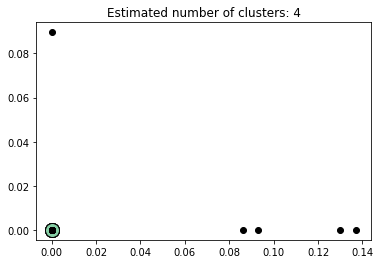

Top terms per cluster:
Cluster 0:
('derivative', 'method', 'regression', 'estimator', 'bias', 'difference', 'function', 'sequence', 'square', 'design')


Cluster 1:
('classifier', 'type', 'np', 'error', 'classification', 'class', 'neyman', 'pearson', 'anomaly', 'paradigm')


Cluster 2:
('tensor', 'rank', 'completion', 'sampling', 'given', 'clustering', 'space', 'data', 'cp', 'problem')


Cluster 3:
('gabp', 'algorithm', 'convergence', 'gaussian', 'definite', 'positive', 'multivariate', 'node', 'extension', 'mg')


min_samples: 3, eps: 3
Estimated number of clusters: 1
Estimated number of noise points: 0


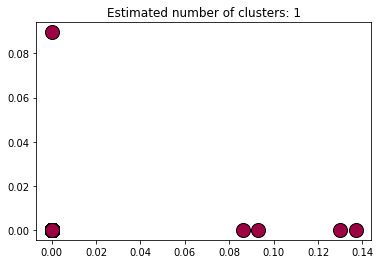

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


min_samples: 5, eps: 0.1
No clusters found
No clusters found
min_samples: 5, eps: 0.3
No clusters found
No clusters found
min_samples: 5, eps: 0.5
No clusters found
No clusters found
min_samples: 5, eps: 1
No clusters found
No clusters found
min_samples: 5, eps: 3
Estimated number of clusters: 1
Estimated number of noise points: 0


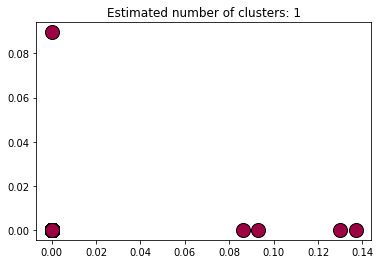

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


min_samples: 10, eps: 0.1
No clusters found
No clusters found
min_samples: 10, eps: 0.3
No clusters found
No clusters found
min_samples: 10, eps: 0.5
No clusters found
No clusters found
min_samples: 10, eps: 1
No clusters found
No clusters found
min_samples: 10, eps: 3
Estimated number of clusters: 1
Estimated number of noise points: 0


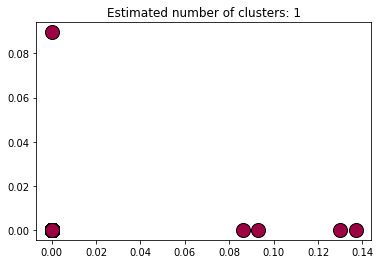

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


min_samples: 20, eps: 0.1
No clusters found
No clusters found
min_samples: 20, eps: 0.3
No clusters found
No clusters found
min_samples: 20, eps: 0.5
No clusters found
No clusters found
min_samples: 20, eps: 1
No clusters found
No clusters found
min_samples: 20, eps: 3
Estimated number of clusters: 1
Estimated number of noise points: 0


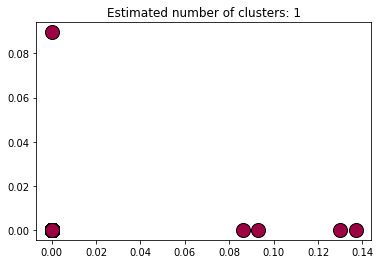

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')




In [14]:
min_samples = [3, 5, 10, 20]
eps_values = [0.1, 0.3, 0.5, 1, 3]

for samples in min_samples:
    for eps in eps_values:
        print(f'min_samples: {samples}, eps: {eps}')
        
        tdidf_dbscan_clustering_alt = DBSCAN(min_samples=samples, eps=eps, n_jobs=6)
        tdidf_dbscan_clustering_alt.fit(tfidf_corpus.toarray())
        
        visualize_clustering_result(tdidf_dbscan_clustering_alt, tfidf_corpus)
        clusters_alt = print_and_get_clusters(tdidf_dbscan_clustering_alt, corpus)
        
        pickle.dump(tdidf_dbscan_clustering_alt, open(f'dbscan_data/dbcan_{samples}_{eps}', 'wb'))

#  Remove words which appear often in all clusters

In [15]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'derivative': 1, 'method': 1, 'regression': 1, 'estimator': 1, 'bias': 1, 'difference': 1, 'function': 1, 'sequence': 1, 'square': 1, 'design': 1, 'classifier': 1, 'type': 1, 'np': 1, 'error': 1, 'classification': 1, 'class': 1, 'neyman': 1, 'pearson': 1, 'anomaly': 1, 'paradigm': 1, 'tensor': 1, 'rank': 1, 'completion': 1, 'sampling': 1, 'given': 1, 'clustering': 1, 'space': 1, 'data': 1, 'cp': 1, 'problem': 1, 'gabp': 1, 'algorithm': 1, 'convergence': 1, 'gaussian': 1, 'definite': 1, 'positive': 1, 'multivariate': 1, 'node': 1, 'extension': 1, 'mg': 1})>

In [36]:
custom_stopwords = ["derivative", "method", "regression", "estimator", "bias"]

In [37]:
corpus_stopwords = load_data()

corpus_stopwords = preprocessing(
    corpus_stopwords,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
90it [00:00, 899.96it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:01, 849.65it/s]


In [38]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_stopwords = vectorizer_stopwords.fit_transform(corpus_stopwords["token"])

In [39]:
tdidf_dbscan_clustering_stopwords = DBSCAN(min_samples=3, eps=1, n_jobs=6)
tdidf_dbscan_clustering_stopwords.fit(tfidf_corpus_stopwords.toarray())

DBSCAN(eps=1, min_samples=3, n_jobs=6)

Estimated number of clusters: 3
Estimated number of noise points: 1252


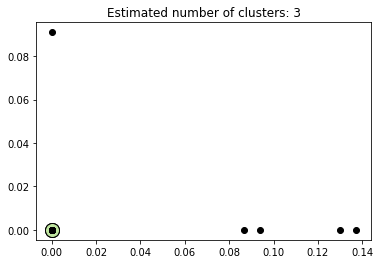

In [40]:
visualize_clustering_result(tdidf_dbscan_clustering_stopwords, tfidf_corpus_stopwords)

In [41]:
clusters = print_and_get_clusters(tdidf_dbscan_clustering_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('classifier', 'type', 'np', 'error', 'classification', 'class', 'neyman', 'pearson', 'anomaly', 'paradigm')


Cluster 1:
('tensor', 'rank', 'completion', 'sampling', 'given', 'clustering', 'space', 'data', 'cp', 'problem')


Cluster 2:
('gabp', 'algorithm', 'convergence', 'gaussian', 'definite', 'positive', 'multivariate', 'node', 'extension', 'mg')




# Metrics

In [42]:
def calc_scores(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), model.labels_), metrics.davies_bouldin_score(corpus.toarray(), model.labels_)

scores = []

score = list(calc_scores(tfidf_corpus, tdidf_dbscan_clustering))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, tdidf_dbscan_clustering_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                    model type  silhouette_score  calinski_harabasz_score  \
0                 normal model         -0.009707                 2.061513   
1  model with custom stopwords         -0.006683                 2.065526   

   davies_bouldin_score  
0              1.887693  
1              1.886362  


# Test with SpectralEmbedding

In [14]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [15]:
tdidf_dbscan_clustering_spectral = DBSCAN(min_samples=3, eps=1, n_jobs=6)
tdidf_dbscan_clustering_spectral.fit(tfidf_corpus_spec_embedding_array)

pickle.dump(tdidf_dbscan_clustering_spectral, open('dbscan_data/tdidf_dbscan_clustering_spectral', 'wb'))

In [16]:
clusters = print_and_get_clusters(tdidf_dbscan_clustering_spectral, corpus)

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')




Estimated number of clusters: 1
Estimated number of noise points: 0


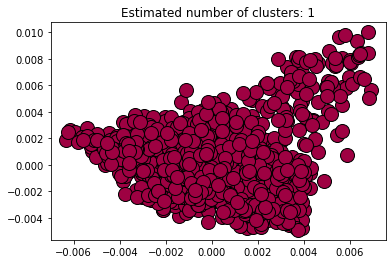

In [17]:
visualize_clustering_result_arr(tdidf_dbscan_clustering_spectral, tfidf_corpus_spec_embedding_array)

In [ ]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

scores = []

score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, tdidf_dbscan_clustering_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

# Test with LSA

In [36]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

In [57]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus)

In [61]:
tdidf_dbscan_clustering_lsa = DBSCAN(min_samples=3, eps=1, n_jobs=6)
tdidf_dbscan_clustering_lsa.fit(X)

pickle.dump(tdidf_dbscan_clustering_lsa, open('dbscan_data/tdidf_dbscan_clustering_lsa', 'wb'))

In [62]:
clusters = print_and_get_clusters(tdidf_dbscan_clustering_lsa, corpus)

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')




Estimated number of clusters: 1
Estimated number of noise points: 0


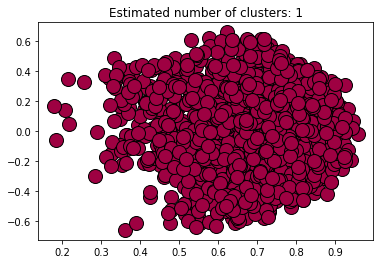

In [63]:
visualize_clustering_result_arr(tdidf_dbscan_clustering_lsa, X)

In [ ]:
scores = []

score = list(calc_scores_arr(X, tdidf_dbscan_clustering_lsa))
score.insert(0, 'model with lsa embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

# Jessis plotting method

In [64]:
def plot(model, corpus, input_dense=False):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    
    if input_dense:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_, marker='x')
    plt.show()

## Normal

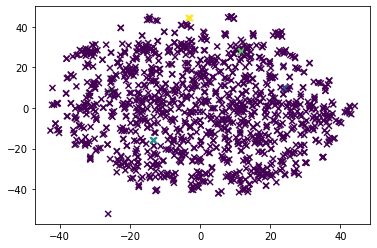

In [66]:
plot(tdidf_dbscan_clustering, tfidf_corpus)

## Spectral

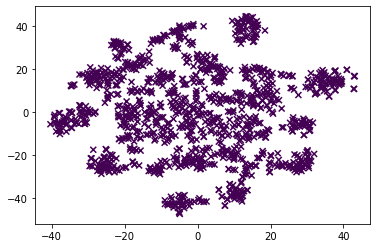

In [68]:
plot(tdidf_dbscan_clustering_spectral, tfidf_corpus_spec_embedding_array, True)

## LSA

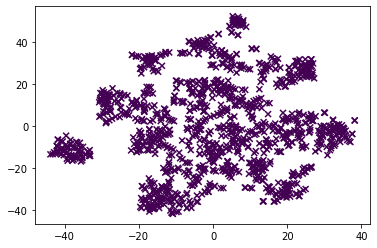

In [70]:
plot(tdidf_dbscan_clustering_lsa, X, True)